In [ ]:
"""
**** READ THIS FIRST ***

Notebook to extract Single molecules from z-stacks of beads

Requirements:
- individual tiffs from a z-series acquisition using MicroManager

Method:
1) creates 3d PSF files (.tif, multipage) from individual tiffs.
2) tiff files must contain "inputChann" strings in the name and will be sorted based on index,
    which is assumed to represent z-slice.
3) IDSM (ID single molecule) takes two parameters: Data, PeakIntensity, Radius
    Data: np.array of your bead stack generated in 2
    PeakIntensity: multiples of the image STD used as a threshold.
        beads whose (peak intensity - image mean intensity) > peak*std will be considered and extracted
    Radius: radius in pixels around the single molecule to extract upon identification.
    Boundary: outer pixels to crop out of consideration for single molecules
        useful if there are severe border aberrations.
4) Average all molecules for each z-plane
5) Visualize to confirm
6) Save

Future Work:
- This code treats each z-plane independently.
    It assumes all molecules in each z-plane are in the same physical plane!
- No support for random bead distribution across a volume!

"""


In [ ]:

import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy


In [6]:
# the only parameters you need to adjust

# file paths
directory = "/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6"
sample = "/Pos0"
outfolder = "/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/"

# Single Molecule Identification parameters
PeakIntensity = 9
radius = 32
boundary = 512

In [7]:
files = [name for name in os.listdir(directory+sample) 
              if os.path.isfile(os.path.join(directory+sample, name))]


In [4]:
inputChann = ['Zyla_405_Widefield', 'Zyla_488_Widefield', 'Zyla_561_Widefield', 'Zyla_637_Widefield']

In [6]:
# generate 3d tiff files (PSF files)

for chan in inputChann:
    tiffstack = []
    
    # pull out images that string match chan
    imglist_by_chan = [directory+sample+"/"+img for img in files if chan in img]
    imglist_by_chan.sort(reverse=False)
    
    # write sorted images to array
    for Image in imglist_by_chan:
        ar = tifffile.imread(Image)
        tiffstack.append(ar)
    tiffstack = np.asarray(tiffstack)
    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
    outfilename = outfolder+"/"+chan+"_tiffstack.tif"
    tifffile.imsave(outfilename, tiffstack)


In [89]:
# load a 3d tiff file (bead stack)
# comment or uncomment to select your wavelength

# stack = tifffile.imread('/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/Zyla_405_Widefield_tiffstack.tif')
# stack = tifffile.imread('/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/Zyla_488_Widefield_tiffstack.tif')
# stack = tifffile.imread('/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/Zyla_561_Widefield_tiffstack.tif')
stack = tifffile.imread('/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/Zyla_637_Widefield_tiffstack.tif')



In [90]:
def trimBorders(playdata, radius):
    copydata = deepcopy(playdata)
    mindat = copydata.min()
    copydata[0:radius].fill(mindat)
    copydata[-radius:-1].fill(mindat)
    copydata[:, 0:radius].fill(mindat)
    copydata[:, -radius:-1].fill(mindat)
    return copydata
    
def triscutData(playdata, size):
    copydata = deepcopy(playdata)
    return copydata[size:-size, size:-size]

def IDSM(inputdata, PeakIntensity, radius, boundary):
    std_input = np.std(inputdata)
    max_data = inputdata.max()
    mean_data = inputdata.mean()
    
    # create copy of input data.
    playdata = deepcopy(inputdata)
    playdata = triscutData(playdata, boundary)
    playdata = trimBorders(playdata, radius)
    extractedList = []
    
    while (max_data - mean_data > std_input * PeakIntensity):
        max_coord = np.unravel_index(playdata.argmax(), playdata.shape)
        
        # extract a radius around this location
        # check that the molecule is not at the edge
        if(playdata.shape[0] - radius > max_coord[0] > radius
            and playdata.shape[1] - radius > max_coord[1] > radius):
            extraction = deepcopy(playdata[ max_coord[0]-radius:max_coord[0]+radius+1 , max_coord[1]-radius:max_coord[1]+radius+1])
        else:
            print("edge molecule detected, replacing molecule but not extracting")
            playdata[ max_coord[0]-radius:max_coord[0]+radius+1 , max_coord[1]-radius:max_coord[1]+radius+1].fill(extractedList[-1].min())
            
        print("extracting molecule # = %s" % (len(extractedList)+1))
        # print("max data = %s, mean_data = %s\nstd_input = %s, PI = %s\nmax-mean = %s, std*PI = %s\ncoord = (%s, %s)" % (max_data, mean_data, std_input, PeakIntensity, max_data - mean_data, std_input * PeakIntensity, max_coord[0], max_coord[1]))
        # print("convergence = %s" % ((max_data - mean_data) - (std_input * PeakIntensity)))
        # print("extraction shape = %s, extraction min = %s" % (extraction.shape, extraction.min()))
        # print("\n")
        
        extractedList.append(extraction)
        
        playdata[ max_coord[0]-radius:max_coord[0]+radius+1 , max_coord[1]-radius:max_coord[1]+radius+1].fill(extraction.min())
            
        #update image data to reflect extracted set
        std_input = np.std(playdata)
        max_data = playdata.max()
        mean_data = playdata.mean()
            
    return extractedList


In [91]:
# create list of z-planes
# each list element is an ndarray of shape (N, x, y), where N is the number of single molecules extracted
#   this (N, x, y) represents all single molecules extracted for that z-plane

newstack = []
for zidx in range(0, stack.shape[0]):
    print("=====================================")
    print("========== z=%s stack =============="%zidx)
    newstack.append(np.asarray(IDSM(stack[zidx], PeakIntensity, radius)))


========== z=0 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20


extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42


extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63


extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88


extracting molecule # = 89
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113


extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
========== z=1 stack ==============
extracting molecule # = 1


extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
========== z=2 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
========== z=3 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
========== z=4 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3


extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
========== z=5 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
========== z=6 stack ==============


extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29


extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
========== z=7 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5


extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35


extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 51
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65


extracting molecule # = 66
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94


extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
========== z=8 stack ==============
extracting molecule # = 1


extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30


extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58


extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87


extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
extracting molecule # = 114
extracting molecule # = 115


extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144


extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
========== z=9 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10


extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40


extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 68
extracting molecule # = 69


extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99


extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 113
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128


extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156


extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule # = 184
extracting molecule # = 185


extracting molecule # = 186
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
========== z=10 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9


extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38


extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67


extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94


extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122


extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150


extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179


extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule # = 184
extracting molecule # = 185
extracting molecule # = 186
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting molecule # = 202
extracting molecule # = 203
extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208


extracting molecule # = 209
extracting molecule # = 210
extracting molecule # = 211
extracting molecule # = 212
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
extracting molecule # = 216
extracting molecule # = 217
extracting molecule # = 218
========== z=11 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19


extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56


extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule 

extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule 

extracting molecule # = 131
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting mol

extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule # = 184
extracting molecule # = 185
extracting molecule # = 186
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting mol

extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
extracting molecule # = 209
extracting molecule # = 210
extracting molecule # = 211
extracting molecule # = 212
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 216
extracting molecule # = 217
extracting molecule # = 218
extracting molecule # = 219
extracting molecule # = 220
extracting molecule # = 221
extracting molecule # = 222
extracting molecule # = 223
extracting molecule # = 224
extracting molecule # = 225
extracting molecule # = 226
extracting molecule # = 227
extracting molecule # = 228
extracting molecule # = 229
extracting molecule # = 230
extracting molecule # = 231
extracting molecule # = 232
========== z=12 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3


extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40


extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77


extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracti

extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting mol

extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 178
extracting molecule # = 179
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule # = 184
extracting mol

extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting molecule # = 202
extracting molecule # = 203
extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
extracting molecule # = 209
extracting molecule # = 210
extracting molecule # = 211
extracting molecule # = 212
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
extracting molecule # = 216
extracting molecule # = 217
extracting molecule # = 218
extracting molecule # = 219
extracting molecule # = 220
extracting molecule # = 221
extracting molecule # = 222
edge molecule detected, replacing molecule but n

extracting molecule # = 226
extracting molecule # = 227
extracting molecule # = 228
extracting molecule # = 229
extracting molecule # = 230
extracting molecule # = 231
extracting molecule # = 232
extracting molecule # = 233
extracting molecule # = 234
========== z=13 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21


extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58


extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95


extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecul

extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting mol

extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule # = 184
extracting molecule # = 185
extracting molecule # = 186
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting mol

extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
extracting molecule # = 209
extracting molecule # = 210
extracting molecule # = 211
extracting molecule # = 212
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
extracting molecule # = 216
extracting molecule # = 217
extracting molecule # = 218
extracting molecule # = 219
extracting molecule # = 220
extracting molecule # = 221
extracting molecule # = 222
extracting molecule # = 223
extracting molecule # = 224
extracting molecule # = 225
extracting molecule # = 226
extracting molecule # = 227
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 228
extracting molecule # = 229
extracting molecule # = 230
extracting molecule # = 231
extracting molecule # = 232
extracting molecule # = 233
extracting molecule # = 234
extracting molecule # = 235
extracting molecule # = 236
========== z=1

extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36


extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73


extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109


extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracti

extracting molecule # = 146
extracting molecule # = 147
extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 177
extracting molecule # = 178
extracting mol

extracting molecule # = 183
extracting molecule # = 184
extracting molecule # = 185
extracting molecule # = 186
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting molecule # = 202
extracting molecule # = 203
extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
extracting molecule # = 209
extracting molecule # = 210
extracting molecule # = 211
extracting molecule # = 212
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
extracting molecule # = 216
extracting molecule # = 217
extracting molecule 

extracting molecule # = 219
extracting molecule # = 220
extracting molecule # = 221
extracting molecule # = 222
extracting molecule # = 223
extracting molecule # = 224
extracting molecule # = 225
extracting molecule # = 226
extracting molecule # = 227
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 228
extracting molecule # = 229
extracting molecule # = 230
extracting molecule # = 231
extracting molecule # = 232
extracting molecule # = 233
extracting molecule # = 234
extracting molecule # = 235
extracting molecule # = 236
extracting molecule # = 237
========== z=15 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10


extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45


extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80


extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
extracting molecule # = 114
extra

extracting molecule # = 118
extracting molecule # = 119
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 148
extracti

extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule # = 184
extracting molecule # = 185
extracting mol

extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting molecule # = 202
extracting molecule # = 203
extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
extracting molecule # = 209
extracting molecule # = 210
extracting molecule # = 211
extracting molecule # = 212
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
extracting molecule # = 216
extracting molecule # = 217
extracting molecule # = 218
extracting molecule # = 219
extracting molecule # = 220
extracting molecule # = 221
extracting molecule # = 222


extracting molecule # = 223
extracting molecule # = 224
extracting molecule # = 225
extracting molecule # = 226
extracting molecule # = 227
extracting molecule # = 228
extracting molecule # = 229
extracting molecule # = 230
extracting molecule # = 231
extracting molecule # = 232
extracting molecule # = 233
extracting molecule # = 234
extracting molecule # = 235
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 236
extracting molecule # = 237
extracting molecule # = 238
extracting molecule # = 239
extracting molecule # = 240
extracting molecule # = 241
========== z=16 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8


extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43


extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 62
extracting molecule # = 63
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
edge molecule detected, replacing molecule but not extracting
extr

extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113


extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147


extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule 

extracting molecule # = 185
extracting molecule # = 186
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting molecule # = 202
extracting molecule # = 203
extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
extracting molecule # = 209
extracting molecule # = 210
extracting molecule # = 211
extracting molecule # = 212
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
extracting molecule # = 216
extracting molecule # = 217
extracting molecule # = 218
extracting molecule # = 219
extracting molecule 

extracting molecule # = 221
extracting molecule # = 222
extracting molecule # = 223
extracting molecule # = 224
extracting molecule # = 225
extracting molecule # = 226
extracting molecule # = 227
extracting molecule # = 228
extracting molecule # = 229
extracting molecule # = 230
extracting molecule # = 231
extracting molecule # = 232
extracting molecule # = 233
extracting molecule # = 234
extracting molecule # = 235
extracting molecule # = 236
extracting molecule # = 237
extracting molecule # = 238
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 239
extracting molecule # = 240
extracting molecule # = 241
extracting molecule # = 242
extracting molecule # = 243
========== z=17 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6


extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36


extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extr

extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106


extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140


extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174


extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule # = 184
extracting molecule # = 185
extracting molecule # = 186
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting molecule # = 202
extracting molecule # = 203
extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
extracting molecule # = 209


extracting molecule # = 210
extracting molecule # = 211
extracting molecule # = 212
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 216
extracting molecule # = 217
extracting molecule # = 218
extracting molecule # = 219
extracting molecule # = 220
extracting molecule # = 221
extracting molecule # = 222
extracting molecule # = 223
extracting molecule # = 224
extracting molecule # = 225
extracting molecule # = 226
extracting molecule # = 227
extracting molecule # = 228
extracting molecule # = 229
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 230
extracting molecule # = 231
extracting molecule # = 232
extracting molecule # = 233
========== z=18 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6


extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting mole

extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
edge molecule detected, replacing molecule but not extracting
extracting m

extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule # = 88
extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112


extracting molecule # = 113
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 122
extracting molecule # = 123
extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting molecule 

extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting molecule # = 157
extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule 

extracting molecule # = 185
extracting molecule # = 186
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192
extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting molecule # = 202
extracting molecule # = 203
extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
extracting molecule # = 209
extracting molecule # = 210
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 211
extracting molecule # = 212
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
extracting molecule # = 216
extracting molecule # = 217
extracting mol

extracting molecule # = 221
extracting molecule # = 222
extracting molecule # = 223
extracting molecule # = 224
extracting molecule # = 225
extracting molecule # = 226
extracting molecule # = 227
extracting molecule # = 228
extracting molecule # = 229
extracting molecule # = 230
extracting molecule # = 231
extracting molecule # = 232
========== z=19 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18


extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52
extracting molecule 

extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule # = 87
extracting molecule 

extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule # = 120
extracting molecule # = 121
extracting molecule # = 1

extracting molecule # = 124
extracting molecule # = 125
extracting molecule # = 126
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracting molecule # = 156
extracting mol

extracting molecule # = 158
extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule # = 184
extracting molecule # = 185
extracting molecule # = 186
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192


extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting molecule # = 202
extracting molecule # = 203
extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
extracting molecule # = 209
extracting molecule # = 210
extracting molecule # = 211
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 212
extracting molecule # = 213
extracting molecule # = 214
extracting molecule # = 215
extracting molecule # = 216
extracting molecule # = 217
extracting molecule # = 218
extracting molecule # = 219
extracting molecule # = 220
extracting molecule # = 221
extracting molecule # = 222
extracting molecule # = 223
extracting molecule # = 224
extracting molecule # = 225
extracting mol

extracting molecule # = 228
extracting molecule # = 229
extracting molecule # = 230
extracting molecule # = 231
extracting molecule # = 232
extracting molecule # = 233
extracting molecule # = 234
extracting molecule # = 235
extracting molecule # = 236
extracting molecule # = 237
extracting molecule # = 238
extracting molecule # = 239
extracting molecule # = 240
========== z=20 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12
extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16


extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
extracting molecule # = 33
extracting molecule # = 34
extracting molecule # = 35
extracting molecule # = 36
extracting molecule # = 37
extracting molecule # = 38
extracting molecule # = 39
extracting molecule # = 40
extracting molecule # = 41
extracting molecule # = 42
extracting molecule # = 43
extracting molecule # = 44
extracting molecule # = 45
extracting molecule # = 46
extracting molecule # = 47
extracting molecule # = 48
extracting molecule # = 49
extracting molecule # = 50
extracting molecule # = 51
extracting molecule # = 52


extracting molecule # = 53
extracting molecule # = 54
extracting molecule # = 55
extracting molecule # = 56
extracting molecule # = 57
extracting molecule # = 58
extracting molecule # = 59
extracting molecule # = 60
extracting molecule # = 61
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 62
extracting molecule # = 63
extracting molecule # = 64
extracting molecule # = 65
extracting molecule # = 66
extracting molecule # = 67
extracting molecule # = 68
extracting molecule # = 69
extracting molecule # = 70
extracting molecule # = 71
extracting molecule # = 72
extracting molecule # = 73
extracting molecule # = 74
extracting molecule # = 75
extracting molecule # = 76
extracting molecule # = 77
extracting molecule # = 78
extracting molecule # = 79
extracting molecule # = 80
extracting molecule # = 81
extracting molecule # = 82
extracting molecule # = 83
extracting molecule # = 84
extracting molecule # = 85
extracting molecule # = 86
extracting molecule 

extracting molecule # = 89
extracting molecule # = 90
extracting molecule # = 91
extracting molecule # = 92
extracting molecule # = 93
extracting molecule # = 94
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 95
extracting molecule # = 96
extracting molecule # = 97
extracting molecule # = 98
extracting molecule # = 99
extracting molecule # = 100
extracting molecule # = 101
extracting molecule # = 102
extracting molecule # = 103
extracting molecule # = 104
extracting molecule # = 105
extracting molecule # = 106
extracting molecule # = 107
extracting molecule # = 108
extracting molecule # = 109
extracting molecule # = 110
extracting molecule # = 111
extracting molecule # = 112
extracting molecule # = 113
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 114
extracting molecule # = 115
extracting molecule # = 116
extracting molecule # = 117
extracting molecule # = 118
extracting molecule # = 119
extracting molecule

extracting molecule # = 125
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 126
edge molecule detected, replacing molecule but not extracting
extracting molecule # = 127
extracting molecule # = 128
extracting molecule # = 129
extracting molecule # = 130
extracting molecule # = 131
extracting molecule # = 132
extracting molecule # = 133
extracting molecule # = 134
extracting molecule # = 135
extracting molecule # = 136
extracting molecule # = 137
extracting molecule # = 138
extracting molecule # = 139
extracting molecule # = 140
extracting molecule # = 141
extracting molecule # = 142
extracting molecule # = 143
extracting molecule # = 144
extracting molecule # = 145
extracting molecule # = 146
extracting molecule # = 147
extracting molecule # = 148
extracting molecule # = 149
extracting molecule # = 150
extracting molecule # = 151
extracting molecule # = 152
extracting molecule # = 153
extracting molecule # = 154
extracting molecule # = 155
extracti

extracting molecule # = 159
extracting molecule # = 160
extracting molecule # = 161
extracting molecule # = 162
extracting molecule # = 163
extracting molecule # = 164
extracting molecule # = 165
extracting molecule # = 166
extracting molecule # = 167
extracting molecule # = 168
extracting molecule # = 169
extracting molecule # = 170
extracting molecule # = 171
extracting molecule # = 172
extracting molecule # = 173
extracting molecule # = 174
extracting molecule # = 175
extracting molecule # = 176
extracting molecule # = 177
extracting molecule # = 178
extracting molecule # = 179
extracting molecule # = 180
extracting molecule # = 181
extracting molecule # = 182
extracting molecule # = 183
extracting molecule # = 184
extracting molecule # = 185
extracting molecule # = 186
extracting molecule # = 187
extracting molecule # = 188
extracting molecule # = 189
extracting molecule # = 190
extracting molecule # = 191
extracting molecule # = 192


extracting molecule # = 193
extracting molecule # = 194
extracting molecule # = 195
extracting molecule # = 196
extracting molecule # = 197
extracting molecule # = 198
extracting molecule # = 199
extracting molecule # = 200
extracting molecule # = 201
extracting molecule # = 202
extracting molecule # = 203
extracting molecule # = 204
extracting molecule # = 205
extracting molecule # = 206
extracting molecule # = 207
extracting molecule # = 208
========== z=21 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
extracting molecule # = 9
extracting molecule # = 10
extracting molecule # = 11
extracting molecule # = 12


extracting molecule # = 13
extracting molecule # = 14
extracting molecule # = 15
extracting molecule # = 16
extracting molecule # = 17
extracting molecule # = 18
extracting molecule # = 19
extracting molecule # = 20
extracting molecule # = 21
extracting molecule # = 22
extracting molecule # = 23
extracting molecule # = 24
extracting molecule # = 25
extracting molecule # = 26
extracting molecule # = 27
extracting molecule # = 28
extracting molecule # = 29
extracting molecule # = 30
extracting molecule # = 31
extracting molecule # = 32
========== z=22 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
extracting molecule # = 8
========== z=23 stack ==============


extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5
extracting molecule # = 6
extracting molecule # = 7
========== z=24 stack ==============
extracting molecule # = 1
extracting molecule # = 2
extracting molecule # = 3
extracting molecule # = 4
extracting molecule # = 5


In [92]:
# average all single molecules in each z-plane 
avg_stack = []
for zidx in range(0, len(newstack)):
    avg_stack.append(np.mean(newstack[zidx], axis=0))


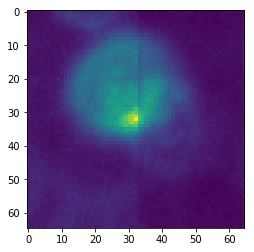

In [70]:
# visualize some planes
plt.imshow(avg_stack[22])

In [93]:
# crop extremes if poor fitting
trunc_stack = avg_stack[1:22]
trunc_stack = np.asarray(trunc_stack, dtype=np.uint16)[:, :-1, :-1]
trunc_stack.shape


(21, 64, 64)

In [ ]:
# save

tifffile.imsave(outfolder+"/637_64x64_2.tif", trunc_stack)


